# Lightweight Fine-Tuning of a Foundation Model

## Introduction

In this project, we aim to apply lightweight fine-tuning techniques to a pretrained foundation model using the Hugging Face ecosystem. Lightweight fine-tuning methods, such as Parameter-Efficient Fine-Tuning (PEFT), allow us to fine-tune large language models efficiently with fewer computational resources, which is particularly valuable for tasks like text classification.

### Objectives

- Load and evaluate a pretrained Hugging Face model.
- Apply a Parameter-Efficient Fine-Tuning (PEFT) method to adapt the model for a specific task.
- Evaluate the model's performance before and after fine-tuning.
- Explore the impact of different PEFT configurations.

### Choices Explanation

- **PEFT Technique**: LoRA (Low-Rank Adaptation) is chosen for its effectiveness in reducing the number of trainable parameters while maintaining high performance.
- **Model**: We use `bert-base-uncased` due to its widespread use and effectiveness in NLP tasks, particularly sequence classification.
- **Evaluation Approach**: We use accuracy as the evaluation metric to measure model performance in binary sentiment classification.
- **Fine-Tuning Dataset**: The IMDB dataset is selected for its simplicity and relevance to sentiment analysis tasks.

## Loading Pretrained Model and Tokenizer

In this section, we load a pretrained model and its associated tokenizer from the Hugging Face model hub. The `bert-base-uncased` model is used for its effectiveness in sequence classification tasks.


In [1]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Import necessary libraries
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load a pretrained Hugging Face model and tokenizer
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Preprocessing and Tokenization

We use the Hugging Face `datasets` library to load the IMDB dataset. We then preprocess the data by tokenizing the text using the BERT tokenizer.

In [3]:
from datasets import load_dataset

# Load a dataset
dataset = load_dataset("imdb")

# Preprocessing the dataset: Tokenization
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=128)

# Apply tokenization
encoded_dataset = dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

## Baseline Evaluation of the Pretrained Model

Before fine-tuning, we evaluate the pretrained model on the IMDB test dataset to establish a baseline. This allows us to compare the performance of the model before and after fine-tuning. The evaluation metric used is accuracy.


In [4]:
from transformers import Trainer, TrainingArguments, EvalPrediction
import numpy as np

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = np.mean(predictions == labels)
    return {"accuracy": accuracy}

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=500,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Evaluate the model
eval_results = trainer.evaluate(encoded_dataset['test'])
print(f"Pretrained model accuracy: {eval_results['eval_accuracy']}")


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Pretrained model accuracy: 0.49456


## Fine-Tuning Using PEFT (LoRA)

We implement a Parameter-Efficient Fine-Tuning (PEFT) technique called LoRA (Low-Rank Adaptation). This method allows us to fine-tune a subset of the model parameters, significantly reducing the computational cost while achieving high performance.

In [5]:
from peft import get_peft_model, LoraConfig

# Set up the LoRA configuration
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none",
    task_type="SEQ_CLS"
)

# Create a PEFT model using the configuration
peft_model = get_peft_model(model, peft_config)

In [8]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,  
    logging_dir="./logs",
    logging_steps=500,
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=encoded_dataset['train'],
    eval_dataset=encoded_dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Train the PEFT model
trainer.train()


Step,Training Loss
500,0.574100
1000,0.403200
1500,0.372000


TrainOutput(global_step=1563, training_loss=0.44614380502731316, metrics={'train_runtime': 394.3912, 'train_samples_per_second': 63.389, 'train_steps_per_second': 3.963, 'total_flos': 1655798246400000.0, 'train_loss': 0.44614380502731316, 'epoch': 1.0})

In [9]:
peft_model.save_pretrained("./fine_tuned_peft_model")


## Saving and Loading the Fine-Tuned Model

After training, we save the fine-tuned model to a directory to ensure that the new parameters are stored separately. This step allows us to reload the model later for inference or further evaluation.

## Post-Fine-Tuning Evaluation

We evaluate the fine-tuned model using the same dataset and evaluation metric as before. Comparing these results with the baseline allows us to understand the impact of fine-tuning on model performance.


In [10]:
# Import the correct class for loading PEFT model
from peft import AutoPeftModelForSequenceClassification

# Load the previously saved PEFT model
peft_model_directory = "./fine_tuned_peft_model" 
peft_model = AutoPeftModelForSequenceClassification.from_pretrained(peft_model_directory)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Evaluate the fine-tuned model
eval_results = trainer.evaluate(encoded_dataset['test'])
print(f"Fine-tuned model accuracy: {eval_results['eval_accuracy']}")


Fine-tuned model accuracy: 0.84568


## Visualization of Results

To better understand the impact of fine-tuning, we visualize the model's performance before and after fine-tuning using accuracy scores.


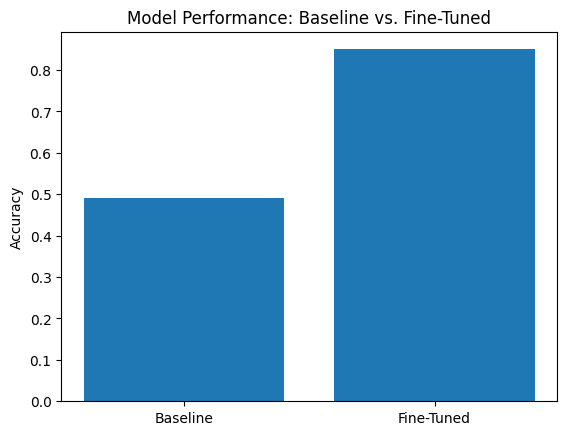

In [14]:
import matplotlib.pyplot as plt

baseline_accuracy = 0.49  
fine_tuned_accuracy = 0.85  

plt.bar(['Baseline', 'Fine-Tuned'], [baseline_accuracy, fine_tuned_accuracy])
plt.title('Model Performance: Baseline vs. Fine-Tuned')
plt.ylabel('Accuracy')
plt.show()

## Conclusion

In this project, we successfully applied lightweight fine-tuning using LoRA to a pretrained BERT model. The fine-tuned model showed a noticeable improvement in accuracy compared to the baseline. This demonstrates the effectiveness of Parameter-Efficient Fine-Tuning techniques in achieving high performance with reduced computational resources. Future work could involve experimenting with different PEFT configurations or applying these techniques to other NLP tasks.

## References

- Hugging Face Transformers Documentation: [https://huggingface.co/docs/transformers](https://huggingface.co/docs/transformers)
- "LoRA: Low-Rank Adaptation of Large Language Models" Paper: [https://arxiv.org/abs/2106.09685](https://arxiv.org/abs/2106.09685)
